# Banana Ripeness Classification

## Image preparation

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Removing invalid images

In [3]:
import cv2
import imghdr

/var/folders/71/z1p57v9j3xx9mtyxfmr4bw5m0000gn/T/ipykernel_1430/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = 'data'
os.listdir(data_dir)
# os.listdir(os.path.join(data_dir, 'unripe'))

['.DS_Store', 'unripe', 'ripe']

In [5]:
# Image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if os.path.isdir(class_path):
        for image in os.listdir(class_path):
            if image == '.DS_Store':
                continue  # Skip .DS_Store files
            image_path = os.path.join(class_path, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print("Image not in ext list: {}".format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print("Issue with image {}: {}".format(image_path, e))
                os.remove(image_path)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


### Load data

In [7]:
from matplotlib import pyplot as plt
import numpy as np

In [22]:
# Create a dataset of those images using keras utils (building our data pipeline)
data = tf.keras.utils.image_dataset_from_directory('data')

Found 322 files belonging to 2 classes.


In [9]:
# Create a data iterator -> allow us to access the data pipeline
data_iterator = data.as_numpy_iterator()

2024-03-10 12:32:45.554975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [322]
	 [[{{node Placeholder/_4}}]]
2024-03-10 12:32:45.555215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [322]
	 [[{{node Placeholder/_4}}]]


In [10]:
# Get a batch of data from the data pipeline
batch = data_iterator.next()

2024-03-10 12:32:45.593405: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-10 12:32:45.709406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 12:32:46.400486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


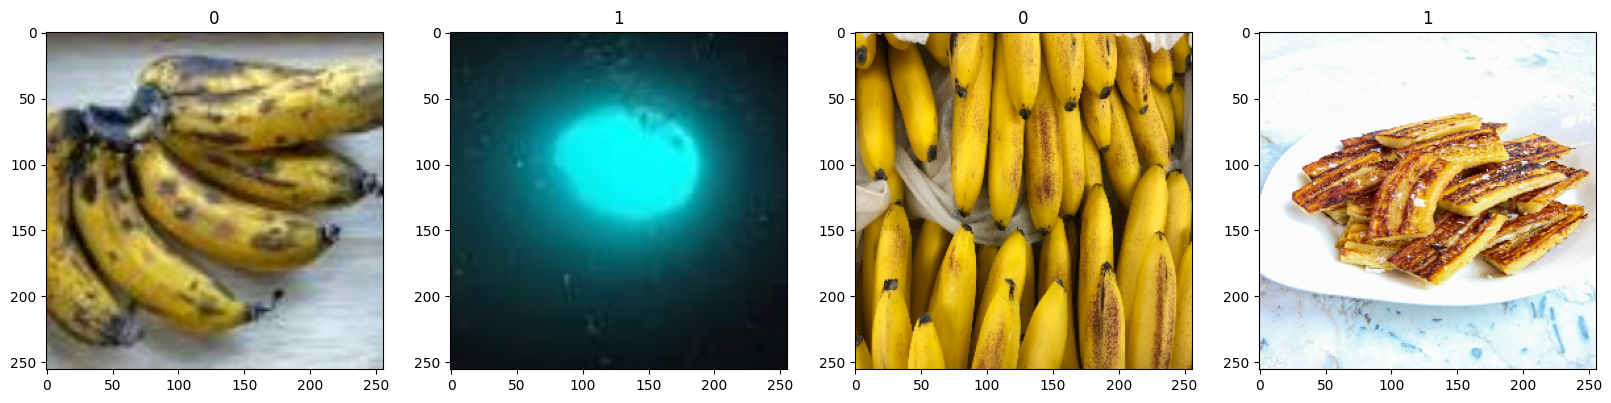

In [11]:
# Visualize a batch 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Based on this batch, 0 represents the ripe bananas and 1 represents the unripe bananas.


CLASS 1 = UNRIPE 
CLASS 0 = RIPE

## Scaling data

Now we need to scale our images into a standard size (255, 255) before using them to train our neural network model

In [23]:
# Divide the image size by 255 while keep the label (y) the same
data = data.map(lambda x, y: (x/255, y))

In [25]:
# Iterate
scaled_iterator = data.as_numpy_iterator()

In [30]:
# Access the image that's scaled from 0 to 1 instead of 0 to 255. 
scaled_batch = scaled_iterator.next()

## Split data

In [39]:
len(data)

11

Our data has 11 batches with each batch containing 29 images and the final batch will contain 32 images for the total batches to contain exactly 322 image files

Let's split the data into three sets: training, validation, and testing sets.

In [42]:
train_size = int(len(data) * 0.7)
print("Training size:", train_size)
validation_size = int(len(data) * 0.2)
print("Validation size:", validation_size)
test_size = int(len(data) * 0.1)
print("Testing size:", test_size)

Training size: 7
Validation size: 2
Testing size: 1


Throughout our model building process, we want to use our training and validation sets while using the testing set for the model's post-training phase to test if our model can be generalized to new images.

Next, we'll want to partition the data with these calculated size.

In [43]:
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size + validation_size).take(test_size)

Now that we have loaded, pre-processed, and partitioned our image dataset, let's head to actually building the deep learning model!

## Deep learning model

### Convolution Neural Network (CNN) Architecture

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

Because our model only takes in one input and produces one output, we choose a Sequential model so that we can stack multiple layers.

In [47]:
model = Sequential()

Now, we're going to add layers into this Sequential model.

In [48]:
# First layer: 16 filers, gathering pixels in a 3x3 grid, move to the next pixel 
# by 1 pixel, using the relu function to keep the negative predictions as 0 
# and positive predictions as positive
# the output size is (256,256) with 3 channels
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

# Because the output of the CNN is a multi-dimensional tensor, we want to 
# convert it into a one-dimensional vector
model.add(Flatten())

# We add neurons with different activation functions to enable for classification learning
model.add(Dense(256, activation='relu'))
model.add(Dense(1,activation='sigmoid'))


Now that we have create the architecture of the CNN, let's compile it using adam optimizer. For loss, since this is a binary classification NN, we're using Binary Cross entropy. Finally, we want to evaluate our model based on accuracy level.

In [51]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

Here's the summary of the model:

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Now that we have created the architecture, let's move on to training our CNN!

### Train CNN

In [52]:
log_dir = 'logs' # save all of the training logs into a directory folder called logs


In [54]:
# Create a TensorBoard for us to access the training logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir) 

Since we're in our training process, we use the .fit() method.

In [55]:
hist = model.fit(train, epochs=20,validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20


2024-03-10 15:50:10.132408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [322]
	 [[{{node Placeholder/_4}}]]
2024-03-10 15:50:10.132802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [322]
	 [[{{node Placeholder/_0}}]]
2024-03-10 15:50:10.582451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:11.238181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.8714 - accuracy: 0.5893

2024-03-10 15:50:13.618497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [322]
	 [[{{node Placeholder/_4}}]]
2024-03-10 15:50:13.618713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [322]
	 [[{{node Placeholder/_4}}]]
2024-03-10 15:50:13.770980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:14.402731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 5s 481ms/step - loss: 0.8714 - accuracy: 0.5893 - val_loss: 0.6148 - val_accuracy: 0.6250
Epoch 2/20


2024-03-10 15:50:14.787181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:15.431792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.7366

2024-03-10 15:50:17.704084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:18.342086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 461ms/step - loss: 0.5449 - accuracy: 0.7366 - val_loss: 0.5536 - val_accuracy: 0.7656
Epoch 3/20


2024-03-10 15:50:18.721959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:19.363717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.5367 - accuracy: 0.7545

2024-03-10 15:50:21.386938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:22.009468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 425ms/step - loss: 0.5367 - accuracy: 0.7545 - val_loss: 0.5124 - val_accuracy: 0.7969
Epoch 4/20


2024-03-10 15:50:22.377788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:23.011228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.4572 - accuracy: 0.8438

2024-03-10 15:50:25.016073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:25.642657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 420ms/step - loss: 0.4572 - accuracy: 0.8438 - val_loss: 0.3039 - val_accuracy: 0.8750
Epoch 5/20


2024-03-10 15:50:26.011759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:26.658145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3646 - accuracy: 0.8705

2024-03-10 15:50:28.985499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:29.621508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 462ms/step - loss: 0.3646 - accuracy: 0.8705 - val_loss: 0.4198 - val_accuracy: 0.8594
Epoch 6/20


2024-03-10 15:50:30.008665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:30.656298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3310 - accuracy: 0.8750

2024-03-10 15:50:32.916832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:33.554222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 460ms/step - loss: 0.3310 - accuracy: 0.8750 - val_loss: 0.4584 - val_accuracy: 0.8438
Epoch 7/20


2024-03-10 15:50:33.938816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:34.581948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3037 - accuracy: 0.9018

2024-03-10 15:50:36.577197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:37.228130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 426ms/step - loss: 0.3037 - accuracy: 0.9018 - val_loss: 0.3428 - val_accuracy: 0.8906
Epoch 8/20


2024-03-10 15:50:37.601963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:38.264875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.2468 - accuracy: 0.9152

2024-03-10 15:50:40.317239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:40.951796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 427ms/step - loss: 0.2468 - accuracy: 0.9152 - val_loss: 0.3495 - val_accuracy: 0.8281
Epoch 9/20


2024-03-10 15:50:41.328433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:41.979601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.9018

2024-03-10 15:50:43.970314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:44.595853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 420ms/step - loss: 0.2232 - accuracy: 0.9018 - val_loss: 0.2106 - val_accuracy: 0.9688
Epoch 10/20


2024-03-10 15:50:44.957575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:45.579715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9375

2024-03-10 15:50:47.562751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:48.185081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 419ms/step - loss: 0.1839 - accuracy: 0.9375 - val_loss: 0.1227 - val_accuracy: 0.9531
Epoch 11/20


2024-03-10 15:50:48.551355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:49.180740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9062

2024-03-10 15:50:51.162393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:51.796936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 421ms/step - loss: 0.2310 - accuracy: 0.9062 - val_loss: 0.2250 - val_accuracy: 0.9219
Epoch 12/20


2024-03-10 15:50:52.162382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:52.797342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.8929

2024-03-10 15:50:54.786379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:55.413621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 421ms/step - loss: 0.2803 - accuracy: 0.8929 - val_loss: 0.1773 - val_accuracy: 0.9219
Epoch 13/20


2024-03-10 15:50:55.785889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:56.414829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.9375

2024-03-10 15:50:58.443952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:50:59.074494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 427ms/step - loss: 0.2111 - accuracy: 0.9375 - val_loss: 0.1625 - val_accuracy: 0.9219
Epoch 14/20


2024-03-10 15:50:59.437005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:00.067549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9464

2024-03-10 15:51:02.060113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:02.686584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 422ms/step - loss: 0.1443 - accuracy: 0.9464 - val_loss: 0.1238 - val_accuracy: 0.9375
Epoch 15/20


2024-03-10 15:51:03.053222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:03.679733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9464

2024-03-10 15:51:05.750844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:06.381307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 434ms/step - loss: 0.1158 - accuracy: 0.9464 - val_loss: 0.1975 - val_accuracy: 0.9531
Epoch 16/20


2024-03-10 15:51:06.748235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:07.383529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9375

2024-03-10 15:51:09.461897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:10.120729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 445ms/step - loss: 0.2020 - accuracy: 0.9375 - val_loss: 0.1881 - val_accuracy: 0.9219
Epoch 17/20


2024-03-10 15:51:10.512450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:11.154784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9554

2024-03-10 15:51:13.454373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:14.113528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 458ms/step - loss: 0.1716 - accuracy: 0.9554 - val_loss: 0.1251 - val_accuracy: 0.9531
Epoch 18/20


2024-03-10 15:51:14.495269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:15.134463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9241

2024-03-10 15:51:17.151280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:17.782061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 422ms/step - loss: 0.2091 - accuracy: 0.9241 - val_loss: 0.1537 - val_accuracy: 0.9531
Epoch 19/20


2024-03-10 15:51:18.151870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:18.777344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9464

2024-03-10 15:51:20.742928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:21.373261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 418ms/step - loss: 0.1768 - accuracy: 0.9464 - val_loss: 0.2122 - val_accuracy: 0.9219
Epoch 20/20


2024-03-10 15:51:21.756953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:22.394583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9330

2024-03-10 15:51:24.366125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 15:51:24.998977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 420ms/step - loss: 0.1450 - accuracy: 0.9330 - val_loss: 0.1535 - val_accuracy: 0.9531


As we can see from the logs, it is good news that our losses went down from 0.87 to 0.15 while our accuracy level increased from 0.625 to 0.93 after 20 times rerunning and retraining our model!

In order to get a better look at our model's training progression, we're going to plot the performance!

### Plot performance

Plotting the loss

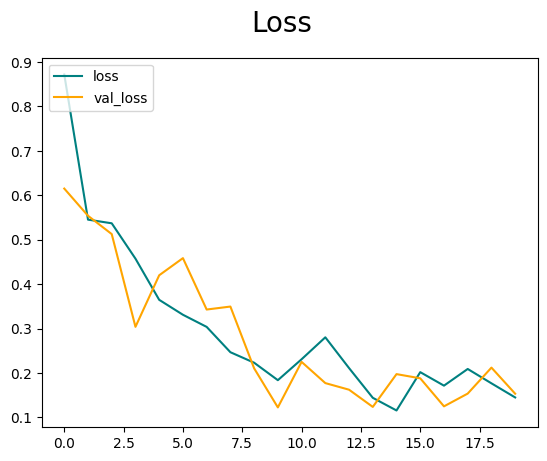

In [56]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label='val_loss')
plt.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

Looking from this plot tells us that because our validation loss is decreasing steadily, it's a sign that the model is not overfitting. 

Plotting the accuracy

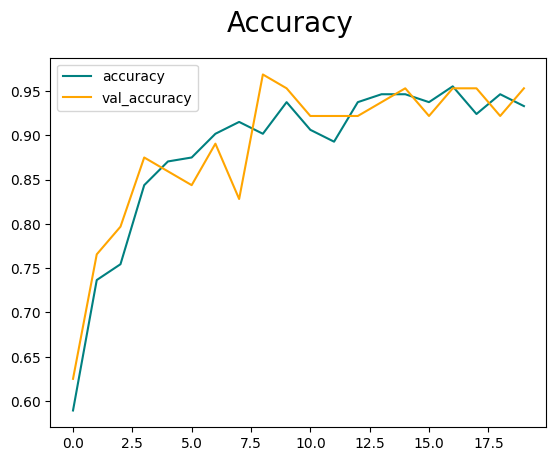

In [60]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label='val_accuracy')
plt.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

Looking at this accuracy plot indicates to us that our accuracy level steadily increased with a spike between our 7.5 to 10 epoch, showing that our accuracy was at a high point and began to dropped. However, at our 20th epoch, our accuracy level was stabilizing so that's a good sign that our model was able to learn the images and how to classify them.

In addition to evaluating our model based on accuracy, we can evaluate it using other metrics: precision and recall.

### Using other metrics

In [61]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [62]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [64]:
for batch in test.as_numpy_iterator():
    X, y = batch # allocate images into X and labels into y
    y_predicted = model.predict(X)
    precision.update_state(y, y_predicted)
    recall.update_state(y, y_predicted)
    accuracy.update_state(y, y_predicted)

2024-03-10 16:09:04.900387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-10 16:09:05.626382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1/1 [==============================] - 0s 196ms/step


In [69]:
print(f"Precision: {precision.result().numpy()}")
print(f"Recall: {recall.result().numpy()}")
print(f"Accuracy: {accuracy.result().numpy()}")

Precision: 0.9444444179534912
Recall: 1.0
Accuracy: 0.96875


#### Interpretation

Precision: when the model is predicting if a banana is ripe, it is correct 94.4% of the time.

Recall: the model is able to correctly identify all of the ripe bananas in the dataset without missing any ripe bananas out. 

Accuracy: Overall, the model correctly identified the ripeness status of a banana 96.88% of the time.

## Testing!

In [70]:
import cv2

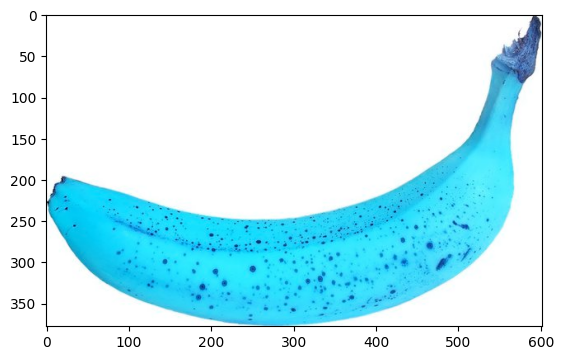

In [74]:
image = cv2.imread('ripe_banana.jpg')
plt.imshow(image)
plt.show()

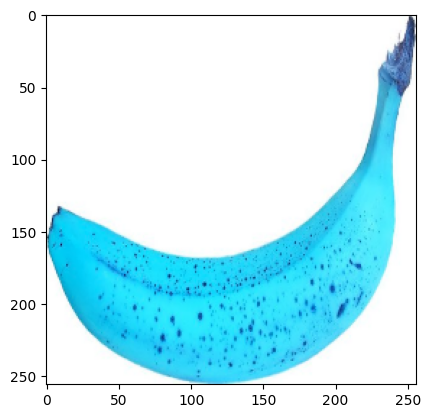

In [75]:
resized_image = tf.image.resize(image, (256, 256))
plt.imshow(resized_image.numpy().astype(int))
plt.show()

Because our model is trained with a batch of images, we use np.expand_dims() to add extra dimensions to mimick a batch of images

In [77]:
y_predicted_test = model.predict(np.expand_dims(resized_image/255, 0))
print("The model predicts: ", y_predicted_test)

1/1 [==============================] - 0s 24ms/step
The model predicts:  [[0.36622328]]


Based on this testing, we get a prediction of 0.366, which according to our cutoff of 0.5, the model accurately predicts that this ripe banana picture is indeed ripe!!

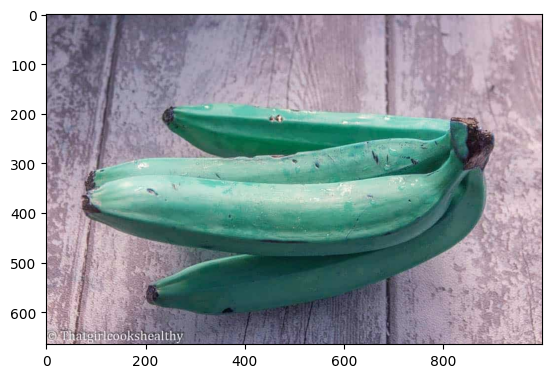

In [78]:
# Let's try the unripe picture.
image2 = cv2.imread('unripe_banana.jpg')
plt.imshow(image2)
plt.show()

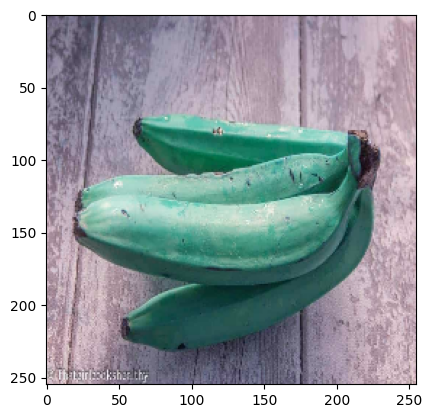

In [80]:
resized_image2 = tf.image.resize(image2, (255,255))
plt.imshow(resized_image2.numpy().astype(int))
plt.show()

In [83]:
y_predicted_test_2 = model.predict(np.expand_dims(resized_image2/255,0))
print("The model predicts", y_predicted_test_2)

1/1 [==============================] - 0s 21ms/step
The model predicts [[0.9698044]]


As we can see, the model accurately predicts that this banana is unripe!

## Saving the model

In [84]:
from tensorflow.keras.models import load_model

In [85]:
model.save(os.path.join('models', 'banana_ripeness_prediction.h5'))

## Conclusion

Throughout this project, I was able to learn the stages in creating and developing a neural network that could learn to predict the ripeness of any banana images. For our statistics, I was able to create a Covolutional Neural Network with a 95% accuracy level with a 15% loss. Though there can be more opportunity to optimize for this and reduce the loss level and icnrease the accuracy level, this project serves as a good starting point for me to begin other neural-network projects!